In [3]:
import os, sys
import torch
import torch.nn as nn
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
cmap = plt.cm.get_cmap("tab10")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
sys.dont_write_bytecode = True
warnings.filterwarnings("ignore")

C:\Users\jhbai\AppData\Local\Temp\ipykernel_144120\1324784796.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


In [14]:
class cpd_model(nn.Module):
    def __init__(self, seq_len, n_seq_min, n_seq_max):
        super(cpd_model, self).__init__()
        self.len_seq = seq_len - n_seq_max

        self.layers = nn.ModuleList()
        for n_seq in range(n_seq_min, n_seq_max+1):
            self.layers.append(nn.Linear(n_seq, 32))
        
        self.cnn_layer = nn.Sequential(
            nn.Conv1d(in_channels=32*(n_seq_max-n_seq_min+1), out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        )
        self.fc = nn.Linear(self.len_seq, 1)
        self.n_seq_min, self.n_seq_max = n_seq_min, n_seq_max
        

    def forward(self, x):
        out = list()
        for i, n_seq in enumerate(range(self.n_seq_min, self.n_seq_max+1)):
            windows = x.unfold(1, n_seq, 1)
            tmp = self.layers[i](windows)
            tmp = torch.diff(tmp, dim = 1)[:, -self.len_seq:, :]
            out.append(tmp)
        out = torch.cat(out, dim = 2).permute(0, 2, 1)
        out = self.cnn_layer(out).reshape(x.shape[0], -1)
        out = nn.Sigmoid()(self.fc(out))
        return out.squeeze(1)
cpd_model(256, 8, 10)(torch.randn(100, 256)).shape
        

torch.Size([100])

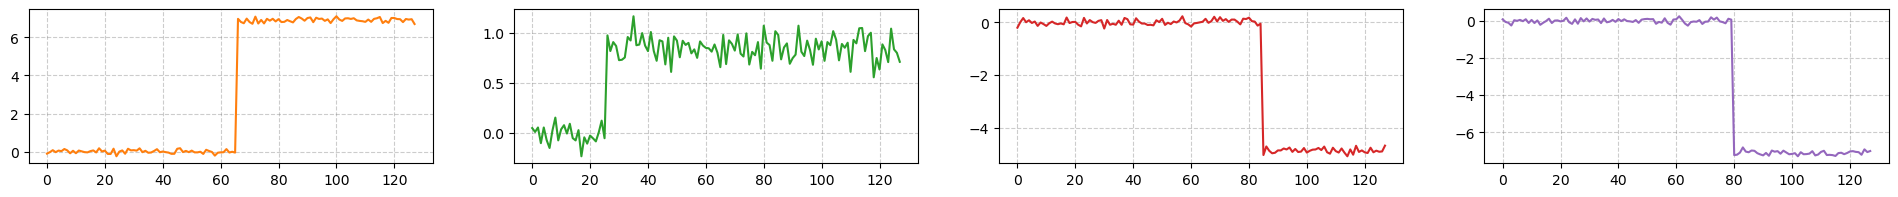

In [63]:
def data_augment(n_size, n_seq, device):
    data = list()

    # ----------------------------------------- #
    # 建立正常label
    # ----------------------------------------- #
    for _ in range(n_size):
        tmp = torch.randn(1, n_seq)
        data += [tmp]


    # ----------------------------------------- #
    # 建立異常label
    # ----------------------------------------- #
    for _ in range(n_size//2):
        tmp = torch.randn(1, n_seq)*0.1
        idx = torch.randperm(n_seq)[0]
        baseline = float(torch.empty(1).uniform_(.5, 10))
        tmp[0, idx:] += baseline
        data += [tmp.clone()]
    for _ in range(n_size//2):
        tmp = torch.randn(1, n_seq)*0.1
        idx = torch.randperm(n_seq)[0]
        baseline = float(torch.empty(1).uniform_(.5, 10))
        tmp[0, idx:] -= baseline
        data += [tmp.clone()]

    data = torch.cat(data, dim = 0)
    labels = torch.cat([torch.zeros(n_size), torch.ones(n_size)], dim = 0)
    return data.to(device), labels.to(device)

check, _ = data_augment(4, 128, "cpu")
fig, ax = plt.subplots(1, 4, figsize = (24, 2))
for i in range(4):
    ax[i].plot(check.tolist()[i+4], color = cmap(i+1))
    ax[i].grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()

In [64]:
from IPython.display import clear_output
n_seq = 256
small_win_size = 32
big_win_size = 64
device = "cuda"
model = cpd_model(n_seq, small_win_size, big_win_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 0
history = list()
while True:
    try:
        epoch += 1
        data, label = data_augment(128, n_seq, device)
        pred = model(data)
        loss = nn.BCELoss()(pred, label)
        history += [loss.item()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        clear_output()
        fig, ax = plt.subplots(1, 1, figsize = (6, 2))
        ax.plot(history, color = "red")
        ax.grid(color = "gray", linestyle = "--", alpha = .4)
        plt.show()
    except:
        break

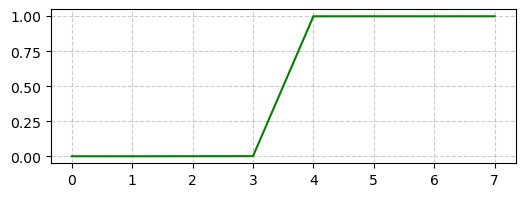

In [65]:
test, _ = data_augment(4, 256, "cuda")
pred_t = model(test).tolist()
fig, ax = plt.subplots(1, 1, figsize = (6, 2))
ax.plot(pred_t, color = "green")
ax.grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()

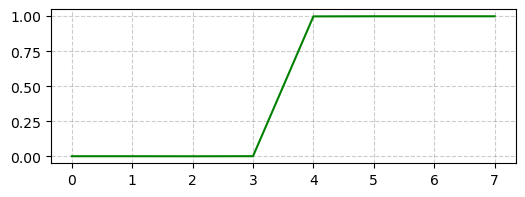

In [69]:
test, _ = data_augment(4, 256, "cuda")
pred_t = model(test*10).tolist()
fig, ax = plt.subplots(1, 1, figsize = (6, 2))
ax.plot(pred_t, color = "green")
ax.grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()

[0.7181688547134399]


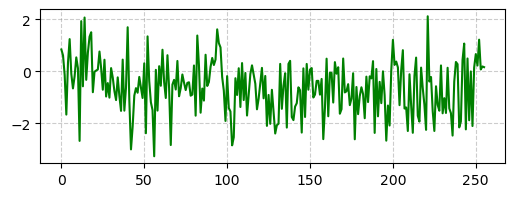

In [77]:
arr = torch.randn(1, n_seq)
arr[0, 30:] -= .58
model(arr.to(device))
pred_t = model(arr.to(device)).tolist()
print(pred_t)
fig, ax = plt.subplots(1, 1, figsize = (6, 2))
ax.plot(arr[0], color = "green")
ax.grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()

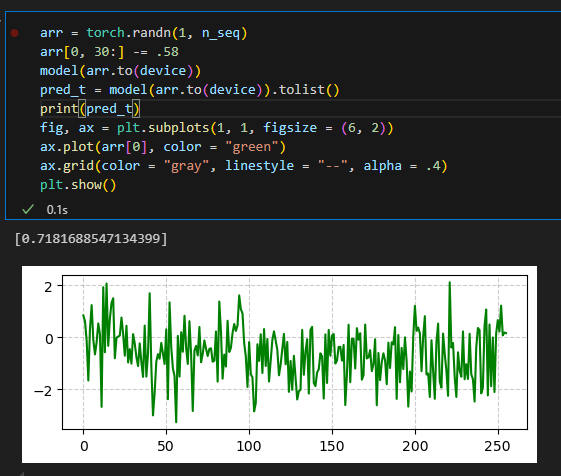